In [2]:
import filegetter.filegetter as fgt
import pandas as pd
df = fgt.get("binance", "swap", "btc-usdt", "trade","20250318", machine="AWS-JP1")
dg = fgt.get("binance", "swap", "btc-usdt", "depth5","20250318", machine="AWS-JP1")
trades_df=df
quotes_df=dg


loading... AWS-JP1_BINANCE_SWAP_BTC-USDT_TRADE_2025_03_18.hdf 
loading... AWS-JP1_BINANCE_SWAP_BTC-USDT_DEPTH5_2025_03_18.hdf 


In [3]:
df

,p,v,ts,local_time,upload_time,source,trade_id
0,83963.0,0.398,1742256004820,1742256004825121767,1742256004852139726,NaN,6113553678
1,83963.0,0.215,1742256004820,1742256004825126770,1742256004852139726,NaN,6113553679
2,83963.0,0.001,1742256004821,1742256004825139498,1742256004852139726,NaN,6113553680
3,83963.0,0.387,1742256004821,1742256004825142119,1742256004852139726,NaN,6113553681
4,83963.0,0.020,1742256004821,1742256004825144440,1742256004852139726,NaN,6113553682
...,...,...,...,...,...,...,...
3166246,82666.1,-0.006,1742342398268,1742342398270669824,1742342398270712758,NaN,6116788695
3166247,82666.2,0.060,1742342398412,1742342398413824483,1742342398413845542,NaN,6116788696
3166248,82666.1,-0.014,1742342398520,1742342398521849402,1742342398521855776,NaN,6116788697
3166249,82666.2,0.002,1742342398819,1742342398821287085,1742342398821292412,NaN,6116788698


In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import poisson
from numba import njit
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
# ===============================================================
# 双边 + 双β(12 & 1.5) 近似双核 Hawkes  + NB 尾  + Platt 校准
# 兼容 tick 0.7.x      —— 20 ms 时间容忍度 & 20 ms 聚合粒度
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# --------------------- 0. 载入并对齐 ---------------------------
TICK_SIZE   = 0.1
TRADES_TOL  = "20ms"      # ← 合并报价–成交的容忍度

trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
trades_df = trades_df.set_index("datetime").sort_index()
dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
dg = dg.set_index("datetime").sort_index()

merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                        on="datetime", direction="backward",
                        tolerance=pd.Timedelta(TRADES_TOL))
            .set_index("datetime")
            .dropna(subset=["bp1", "ap1"]))

print("merge 成功行数 =", len(merged))

merged["mid"]        = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged               = merged[merged["delta_tick"] != 0]

merged = merged.resample("20ms").sum(min_count=1).dropna(subset=["p"])
print("20 ms 聚合后行数 =", len(merged))

# --- 0‑4 计算同档排队深度 q_front ------------------------------
def depth_same_row(row, max_lv=5):
    d = int(row["delta_tick"])
    lv = max(1, min(abs(d), max_lv))      # 档位号 1~5
    return row[f"bv{lv}"] if d < 0 else row[f"av{lv}"]

merged["q_front"] = merged.apply(depth_same_row, axis=1).astype(float)

# 还可选：累加前档深度（吃 bp4 必须先吃 bp1‑bp3）
def cumsum_depth(row, max_lv=5):
    d = int(row["delta_tick"])
    if d < 0:
        return sum(row[f"bv{lv}"] for lv in range(1, min(abs(d),max_lv)+1))
    else:
        return sum(row[f"av{lv}"] for lv in range(1, min(abs(d),max_lv)+1))
merged["q_front_cum"] = merged.apply(cumsum_depth, axis=1).astype(float)




merge 成功行数 = 809922
20 ms 聚合后行数 = 150741


In [7]:
merged[["bp1","bp2","bp3","bp4","bp5","delta_tick","q_front_cum","p","mid"]][1000:1050]

,bp1,bp2,bp3,bp4,bp5,delta_tick,q_front_cum,p,mid
datetime,,,,,,,,,
2025-03-18 00:21:10.560,167862.8,167862.6,167862.4,167862.2,167861.6,2.0,15.750,167863.0,167862.90
2025-03-18 00:21:10.780,83931.4,83931.3,83931.2,83931.1,83930.8,-1.0,7.353,83931.4,83931.45
2025-03-18 00:21:10.840,83931.4,83931.3,83931.2,83931.1,83930.8,1.0,7.827,83931.5,83931.45
2025-03-18 00:21:11.640,167862.8,167862.6,167862.4,167862.2,167861.6,2.0,15.298,167863.0,167862.90
2025-03-18 00:21:14.200,83931.4,83931.3,83931.2,83931.1,83930.8,1.0,6.676,83931.5,83931.45
2025-03-18 00:21:15.320,83931.4,83931.3,83931.2,83931.1,83930.8,1.0,4.687,83931.5,83931.45
2025-03-18 00:21:15.820,83931.4,83931.3,83931.2,83931.1,83930.9,1.0,7.746,83931.5,83931.45
2025-03-18 00:21:16.500,83931.4,83931.3,83931.2,83931.1,83930.9,1.0,8.191,83931.5,83931.45
2025-03-18 00:21:16.980,83931.4,83931.3,83931.2,83931.1,83930.9,1.0,2.321,83931.5,83931.45


20 ms 聚合后行数 = 150741
买单事件 81118, 卖单事件 69462
[buy ] μ=0.530, α1=0.220, α2=0.647
[sell] μ=0.463, α1=0.225, α2=0.622


/home/luchen/filegetter-1/.venv/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:336: RuntimeWarning: divide by zero encountered in _nbinom_cdf
  return _boost._nbinom_cdf(k, n, p)


采样点 = 150741
    q_my    T       N     Brier       AUC
6    4.0  0.1  150741  0.003010  0.811157
5    3.0  0.1  150741  0.003542  0.821316
4    2.0  0.1  150741  0.004659  0.834899
3    1.0  0.1  150741  0.007059  0.855165
13   4.0  0.3  150741  0.008488  0.792832
12   3.0  0.3  150741  0.010304  0.803784
11   2.0  0.3  150741  0.013236  0.817814
20   4.0  0.5  150741  0.014168  0.797323
19   3.0  0.5  150741  0.016948  0.806181
10   1.0  0.3  150741  0.019009  0.839467
18   2.0  0.5  150741  0.021438  0.817430
27   4.0  1.0  150741  0.027811  0.793963
17   1.0  0.5  150741  0.029100  0.835276
26   3.0  1.0  150741  0.032839  0.802302
2    0.5  0.1  150741  0.035973  0.856946


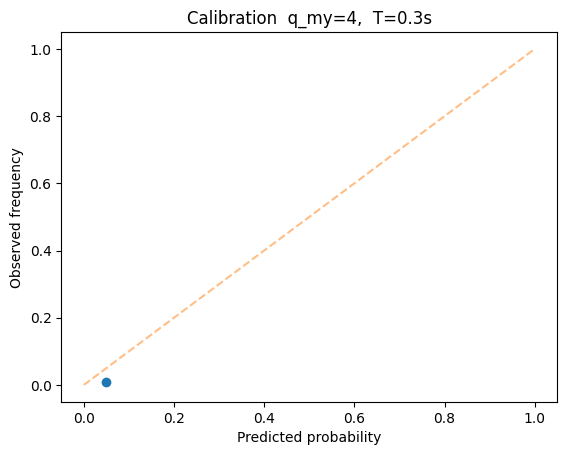

In [8]:
# -------- 0-bis. 20 ms 聚合 ------------------------------------
merged = merged.resample("20ms").sum(min_count=1).dropna(subset=["p"])
print("20 ms 聚合后行数 =", len(merged))


# --------------------- 1. 事件拆分 ------------------------------
mask_buy  = merged["v"] > 0
mask_sell = merged["v"] < 0

# ① 把 DatetimeIndex 一次性转换成 int64（单位：纳秒）
idx_ns = merged.index.view("int64")          # ndarray[int64]
t0_sec = idx_ns[0] / 1e9                     # 基准秒

# ② 得到买 / 卖事件秒数向量
ev_buy  = (idx_ns[mask_buy ] / 1e9 - t0_sec).astype(float)
ev_sell = (idx_ns[mask_sell] / 1e9 - t0_sec).astype(float)

print(f"买单事件 {len(ev_buy)}, 卖单事件 {len(ev_sell)}")

# --------------------- 2. 双 β Hawkes 拟合 ----------------------
β_short, β_long = 12.0, 1.5       

def fit_one_beta(events, beta_fixed):
    hk = HawkesExpKern(decays=[[beta_fixed]], max_iter=60)
    hk.fit([events])
    return hk.baseline[0], hk.adjacency[0, 0]

μ1_b, α1_b = fit_one_beta(ev_buy , β_short)
μ2_b, α2_b = fit_one_beta(ev_buy , β_long)
μb_hat     = 0.5 * (μ1_b + μ2_b)

μ1_s, α1_s = fit_one_beta(ev_sell, β_short)
μ2_s, α2_s = fit_one_beta(ev_sell, β_long)
μs_hat     = 0.5 * (μ1_s + μ2_s)

print(f"[buy ] μ={μb_hat:.3f}, α1={α1_b:.3f}, α2={α2_b:.3f}")
print(f"[sell] μ={μs_hat:.3f}, α1={α1_s:.3f}, α2={α2_s:.3f}")

# --------------------- 3. λ₀(t) 近似双核 ------------------------
@njit
def lambda_dual(events, tgrid, μ, α1, α2, β1, β2, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            acc += α1 * np.exp(-β1 * dt) + α2 * np.exp(-β2 * dt)
        lam[i] = μ + acc
    return lam

SAMPLE_MS  = "5ms"
samples    = (merged[["delta_tick", "q_front_cum"]]
              .resample(SAMPLE_MS).first().dropna())
t_grid     = samples.index.view("int64") / 1e9

λ_buy  = lambda_dual(ev_buy , t_grid, μb_hat, α1_b, α2_b, β_short, β_long)
λ_sell = lambda_dual(ev_sell, t_grid, μs_hat, α1_s, α2_s, β_short, β_long)
λ0     = np.where(samples["delta_tick"].to_numpy() > 0, λ_buy, λ_sell)

# --------------------- 4. Λ(T) + NB 尾概率 ----------------------
q_my_list = [0.1, 0.3, 0.5, 1, 2, 3, 4]
T_list    = [0.1, 0.3, 0.5, 1, 2, 3, 4]
κ         = 1.8

L0    = λ0[:, None]
T_arr = np.array(T_list)[None, :]
Λ     = μb_hat * T_arr + (L0 - μb_hat) * (1 - np.exp(-β_long * T_arr)) / β_long

need = samples["q_front_cum"].to_numpy()[:, None] + np.array(q_my_list)[None, :]

def nb_tail(n, Lam, kappa):
    Lam   = np.maximum(Lam, 1e-12)
    kappa = max(kappa, 1.0001)
    r, p  = Lam / (kappa - 1), 1 / kappa
    return 1 - nbinom.cdf(n - 1, r, p)

P_raw = nb_tail(need[:, None, :], Λ[:, :, None], κ)

# --------------------- 5. label --------------------------------
cumvol   = np.concatenate(([0.], np.cumsum(merged["v"].abs())))
evt_time = merged.index.view("int64") / 1e9 - t0_sec

def fills(T):
    right = np.searchsorted(evt_time, (t_grid - t0_sec) + T, "right")
    left  = np.searchsorted(evt_time, (t_grid - t0_sec),       "right")
    return cumvol[right] - cumvol[left]

fills_mat = np.vstack([fills(T) for T in T_list]).T
label     = fills_mat[:, :, None] >= need[:, None, :]

# --------------------- 6. Platt 校准 ---------------------------
mask  = ~np.isnan(P_raw)
X     = P_raw[mask].reshape(-1, 1)
platt = LogisticRegression(C=1e6, max_iter=400).fit(X, label[mask])

P_cal         = np.full_like(P_raw, np.nan)
P_cal[mask]   = platt.predict_proba(X)[:, 1]

# --------------------- 7. 回测指标 ------------------------------
records = []
for j, T in enumerate(T_list):
    for k, q in enumerate(q_my_list):
        p, y = P_cal[:, j, k], label[:, j, k]
        m    = ~np.isnan(p)
        if m.sum() < 500 or y[m].astype(int).ptp() == 0:
            continue
        brier = brier_score_loss(y[m], p[m])
        auc   = roc_auc_score(y[m], p[m])
        records.append((q, T, m.sum(), brier, auc))

result = (pd.DataFrame(records, columns=["q_my", "T", "N", "Brier", "AUC"])
          .sort_values("Brier"))
print("采样点 =", len(samples))
print(result.head(15))

# --------------------- 8. 校准曲线 ------------------------------
sel_q, sel_T = 4, 0.3
j, k         = T_list.index(sel_T), q_my_list.index(sel_q)

m     = ~np.isnan(P_cal[:, j, k])
bins  = pd.cut(P_cal[m, j, k], bins=np.linspace(0, 1, 11))
cal   = pd.Series(label[m, j, k]).groupby(bins).mean()

x_mid = cal.index.map(lambda iv: iv.mid)
y_val = cal.values

plt.plot(x_mid, y_val, "o-")
plt.plot([0, 1], [0, 1], "--", alpha=.5)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration  q_my={sel_q},  T={sel_T}s")
plt.show()

# 一档Cross回测

merge 成功行数 = 809922
20 ms 聚合后行数 = 150741
买单事件 81118, 卖单事件 69462
[buy ] μ=0.530, α1=0.220, α2=0.647
[sell] μ=0.463, α1=0.225, α2=0.622
采样点 = 150741
    q_my    T       N     Brier       AUC
42   0.1  4.0  150741  0.002588  0.699777
43   0.3  4.0  150741  0.002589  0.699626
44   0.5  4.0  150741  0.002590  0.700741
45   1.0  4.0  150741  0.002592  0.696504
46   2.0  4.0  150741  0.002599  0.694974
47   3.0  4.0  150741  0.002606  0.693742
48   4.0  4.0  150741  0.002615  0.692639
35   0.1  3.0  150741  0.002878  0.705398
36   0.3  3.0  150741  0.002879  0.705587
37   0.5  3.0  150741  0.002880  0.706584
38   1.0  3.0  150741  0.002883  0.702457
39   2.0  3.0  150741  0.002890  0.700552
40   3.0  3.0  150741  0.002899  0.699067
41   4.0  3.0  150741  0.002908  0.698141
28   0.1  2.0  150741  0.003416  0.699039


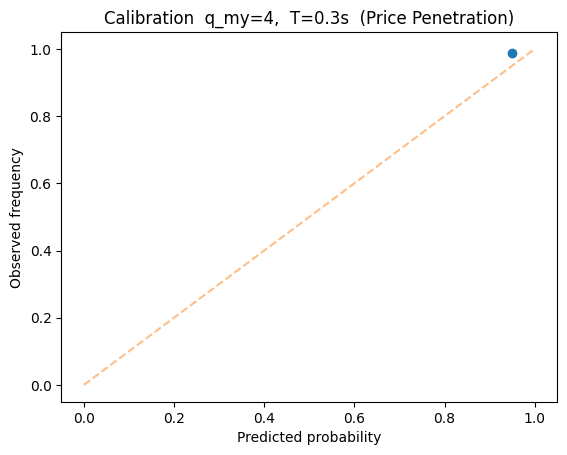

In [9]:
# ===============================================================
# 双边 + 双β(12 & 1.5) 近似双核 Hawkes  + NB 尾  + Platt 校准
# *真实* 成交标签：价格穿越  (price penetration)
# 兼容 tick 0.7.x      —— 20 ms 时间容忍度 & 20 ms 聚合粒度
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# --------------------- 0. 载入并对齐 ---------------------------------
TICK_SIZE   = 0.1
TRADES_TOL  = "20ms"      # ← 合并报价–成交的容忍度

trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
trades_df = trades_df.set_index("datetime").sort_index()

dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
dg = dg.set_index("datetime").sort_index()

merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                        on="datetime", direction="backward",
                        tolerance=pd.Timedelta(TRADES_TOL))
            .set_index("datetime")
            .dropna(subset=["bp1", "ap1"]))

print("merge 成功行数 =", len(merged))

merged["mid"]        = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged               = merged[merged["delta_tick"] != 0]

# ------------- 0-bis. 20 ms 聚合（保持 bp1 / ap1 的首值） ------------
agg = {"p":"sum", "v":"sum", "delta_tick":"first",
       "bp1":"first", "ap1":"first",
       "bv1":"first","bv2":"first","bv3":"first","bv4":"first","bv5":"first",
       "av1":"first","av2":"first","av3":"first","av4":"first","av5":"first"}
merged = (merged.resample("20ms").agg(agg)
                 .dropna(subset=["p","bp1","ap1"]))
print("20 ms 聚合后行数 =", len(merged))

# -------- 0-4. 计算同档排队深度（如需保留原特征可继续使用） ----------
def depth_same_row(row, max_lv=5):
    d = int(row["delta_tick"])
    lv = max(1, min(abs(d), max_lv))
    return row[f"bv{lv}"] if d < 0 else row[f"av{lv}"]

merged["q_front"] = merged.apply(depth_same_row, axis=1).astype(float)

# (可选) 累计前档深度
def cumsum_depth(row, max_lv=5):
    d = int(row["delta_tick"])
    rng = range(1, min(abs(d), max_lv) + 1)
    if d < 0:
        return sum(row[f"bv{lv}"] for lv in rng)
    else:
        return sum(row[f"av{lv}"] for lv in rng)
merged["q_front_cum"] = merged.apply(cumsum_depth, axis=1).astype(float)

# --------------------- 1. 事件拆分 ------------------------------
mask_buy  = merged["v"] > 0          # 主动买 → 成交价高 → 我方卖单
mask_sell = merged["v"] < 0          # 主动卖 → 成交价低 → 我方买单

idx_ns = merged.index.view("int64")          # 纳秒
t0_sec = idx_ns[0] / 1e9

ev_buy  = (idx_ns[mask_buy ] / 1e9 - t0_sec).astype(float)
ev_sell = (idx_ns[mask_sell] / 1e9 - t0_sec).astype(float)
print(f"买单事件 {len(ev_buy)}, 卖单事件 {len(ev_sell)}")

# --------------------- 2. 双 β Hawkes 拟合 ----------------------
β_short, β_long = 12.0, 1.5        # 80 ms & 0.7 s

def fit_one_beta(events, beta_fixed):
    hk = HawkesExpKern(decays=[[beta_fixed]], max_iter=60)
    hk.fit([events])
    return hk.baseline[0], hk.adjacency[0, 0]

μ1_b, α1_b = fit_one_beta(ev_buy , β_short)
μ2_b, α2_b = fit_one_beta(ev_buy , β_long)
μb_hat     = 0.5 * (μ1_b + μ2_b)

μ1_s, α1_s = fit_one_beta(ev_sell, β_short)
μ2_s, α2_s = fit_one_beta(ev_sell, β_long)
μs_hat     = 0.5 * (μ1_s + μ2_s)

print(f"[buy ] μ={μb_hat:.3f}, α1={α1_b:.3f}, α2={α2_b:.3f}")
print(f"[sell] μ={μs_hat:.3f}, α1={α1_s:.3f}, α2={α2_s:.3f}")

# --------------------- 3. λ₀(t) 近似双核 ------------------------
@njit
def lambda_dual(events, tgrid, μ, α1, α2, β1, β2, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            acc += α1 * np.exp(-β1 * dt) + α2 * np.exp(-β2 * dt)
        lam[i] = μ + acc
    return lam

SAMPLE_MS  = "5ms"
samples    = (merged[["delta_tick", "q_front_cum", "bp1", "ap1"]]
              .resample(SAMPLE_MS).first().dropna())
t_grid     = samples.index.view("int64") / 1e9

λ_buy  = lambda_dual(ev_buy , t_grid, μb_hat, α1_b, α2_b, β_short, β_long)
λ_sell = lambda_dual(ev_sell, t_grid, μs_hat, α1_s, α2_s, β_short, β_long)
λ0     = np.where(samples["delta_tick"].to_numpy() > 0, λ_buy, λ_sell)

# --------------------- 4. Λ(T) + NB 尾概率 ----------------------
q_my_list = [0.1, 0.3, 0.5, 1, 2, 3, 4]   # 仍保留原维度，便于对照
T_list    = [0.1, 0.3, 0.5, 1, 2, 3, 4]
κ         = 1.8

L0    = λ0[:, None]                        # λ₀(t) 列向量
T_arr = np.array(T_list)[None, :]
Λ     = μb_hat * T_arr + (L0 - μb_hat) * (1 - np.exp(-β_long * T_arr)) / β_long

need = samples["q_front_cum"].to_numpy()[:, None] + np.array(q_my_list)[None, :]

def nb_tail(n, Lam, kappa):
    Lam   = np.maximum(Lam, 1e-12)
    kappa = max(kappa, 1.0001)
    r, p  = Lam / (kappa - 1), 1 / kappa
    return 1 - nbinom.cdf(n - 1, r, p)

P_raw = nb_tail(need[:, None, :], Λ[:, :, None], κ)

# --------------------- 5. 价格穿越标签 --------------------------
# trades 全量（未聚合！）时间 & 价格
trade_times = trades_df.index.view("int64") / 1e9 - t0_sec   # 秒
trade_price = trades_df["p"].to_numpy()

side_buy   = samples["delta_tick"].to_numpy() < 0            # 我方挂买单
p_order    = np.where(side_buy, samples["bp1"], samples["ap1"])

def price_penetration(T):
    """返回长度 = len(samples) 的布尔向量"""
    left_idx  = np.searchsorted(trade_times, t_grid - t0_sec, side="right")
    right_idx = np.searchsorted(trade_times, (t_grid - t0_sec) + T, side="right")
    out = np.zeros(len(t_grid), dtype=bool)
    for i in range(len(t_grid)):
        l, r = left_idx[i], right_idx[i]
        if l == r:
            continue
        window_prices = trade_price[l:r]
        if side_buy[i]:
            out[i] = (window_prices <= p_order[i]).any()   # buy: 价格向下穿越
        else:
            out[i] = (window_prices >= p_order[i]).any()   # sell: 价格向上穿越
    return out

# 价格穿越标签矩阵：shape = (N_sample, N_T, N_q) —— 第三维复制即可
label_T = np.vstack([price_penetration(T) for T in T_list]).T   # (N, N_T)
label   = np.repeat(label_T[:, :, None], len(q_my_list), axis=2)

# --------------------- 6. Platt 校准 ---------------------------
mask  = ~np.isnan(P_raw)
X     = P_raw[mask].reshape(-1, 1)
platt = LogisticRegression(C=1e6, max_iter=400).fit(X, label[mask])

P_cal         = np.full_like(P_raw, np.nan)
P_cal[mask]   = platt.predict_proba(X)[:, 1]

# --------------------- 7. 回测指标 ------------------------------
records = []
for j, T in enumerate(T_list):
    for k, q in enumerate(q_my_list):
        p, y = P_cal[:, j, k], label[:, j, k]
        m    = ~np.isnan(p)
        if m.sum() < 500 or y[m].astype(int).ptp() == 0:
            continue
        brier = brier_score_loss(y[m], p[m])
        auc   = roc_auc_score(y[m], p[m])
        records.append((q, T, m.sum(), brier, auc))

result = (pd.DataFrame(records, columns=["q_my", "T", "N", "Brier", "AUC"])
          .sort_values("Brier"))
print("采样点 =", len(samples))
print(result.head(15))

# --------------------- 8. 校准曲线示例 --------------------------
sel_q, sel_T = 4, 0.3
j, k         = T_list.index(sel_T), q_my_list.index(sel_q)

m     = ~np.isnan(P_cal[:, j, k])
bins  = pd.cut(P_cal[m, j, k], bins=np.linspace(0, 1, 11))
cal   = pd.Series(label[m, j, k]).groupby(bins).mean()

x_mid = cal.index.map(lambda iv: iv.mid)
y_val = cal.values

plt.plot(x_mid, y_val, "o-")
plt.plot([0, 1], [0, 1], "--", alpha=.5)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration  q_my={sel_q},  T={sel_T}s  (Price Penetration)")
plt.show()


# 各档位Cross回测

样本点数 = 150741
    q_my    T       N     Brier       AUC
42   0.1  4.0  150741  0.005646  0.487865
43   0.3  4.0  150741  0.005647  0.488009
44   0.5  4.0  150741  0.005647  0.489169
45   1.0  4.0  150741  0.005650  0.480135
46   2.0  4.0  150741  0.005653  0.477965
47   3.0  4.0  150741  0.005657  0.476365
48   4.0  4.0  150741  0.005659  0.475283
35   0.1  3.0  150741  0.006331  0.490827
36   0.3  3.0  150741  0.006331  0.491306
37   0.5  3.0  150741  0.006332  0.492271
38   1.0  3.0  150741  0.006334  0.482598
39   2.0  3.0  150741  0.006338  0.480214
40   3.0  3.0  150741  0.006341  0.478749
41   4.0  3.0  150741  0.006343  0.477850
28   0.1  2.0  150741  0.007460  0.484154


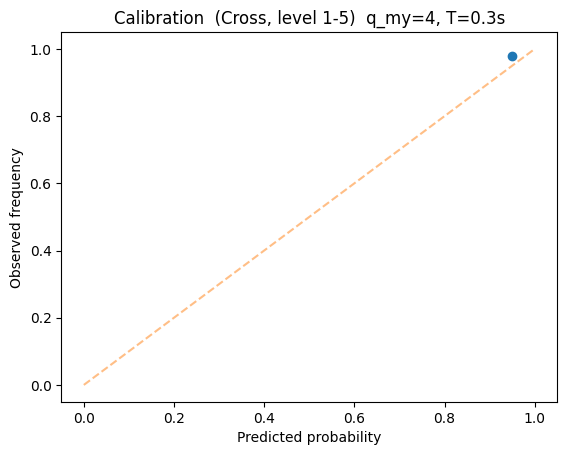

In [ ]:
# ===============================================================
# Cross-label + 动态档位(1-5) + 队列深度特征（Python 3.9+）
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# --------------------- 0. 载入并对齐 ---------------------------------
TICK_SIZE   = 0.1
TRADES_TOL  = "20ms"          # 报价撮合对齐容忍度
RESAMPLE_OB = "20ms"          # Order-book 聚合粒度
RESAMPLE_FE = "5ms"           # Feature 采样粒度

trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
trades_df = trades_df.set_index("datetime").sort_index()

dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
dg = dg.set_index("datetime").sort_index()

merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                        on="datetime", direction="backward",
                        tolerance=pd.Timedelta(TRADES_TOL))
            .set_index("datetime")
            .dropna(subset=["bp1", "ap1"]))

# --------------------- 0-bis. 20 ms 聚合 ------------------------------
agg = {                        # 流量列求和；状态列取窗口首值
    "p":"sum", "v":"sum", "delta_tick":"first",
    "bp1":"first","bp2":"first","bp3":"first","bp4":"first","bp5":"first",
    "ap1":"first","ap2":"first","ap3":"first","ap4":"first","ap5":"first",
    "bv1":"first","bv2":"first","bv3":"first","bv4":"first","bv5":"first",
    "av1":"first","av2":"first","av3":"first","av4":"first","av5":"first"
}

merged["mid"] = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged = merged[merged["delta_tick"] != 0]          # 过滤 mid 成交

merged = (merged
          .resample(RESAMPLE_OB).agg(agg)
          .dropna(subset=["p","bp1","ap1"]))


# --------------------- 1. 事件拆分（Hawkes） ---------------------------
mask_buy  = merged["v"] > 0
mask_sell = merged["v"] < 0

idx_ns = merged.index.view("int64")
t0_sec = idx_ns[0] / 1e9
ev_buy  = (idx_ns[mask_buy ] / 1e9 - t0_sec).astype(float)
ev_sell = (idx_ns[mask_sell] / 1e9 - t0_sec).astype(float)

# --------------------- 2. 双 β Hawkes 拟合 ----------------------------
β_s, β_l = 12.0, 1.5      # 80 ms, 0.7 s

def fit_one_beta(events, beta_fixed):
    hk = HawkesExpKern(decays=[[beta_fixed]], max_iter=60)
    hk.fit([events])
    return hk.baseline[0], hk.adjacency[0, 0]

μ1_b, α1_b = fit_one_beta(ev_buy , β_s)
μ2_b, α2_b = fit_one_beta(ev_buy , β_l)
μb = 0.5 * (μ1_b + μ2_b)

μ1_s, α1_s = fit_one_beta(ev_sell, β_s)
μ2_s, α2_s = fit_one_beta(ev_sell, β_l)
μs = 0.5 * (μ1_s + μ2_s)

# --------------------- 3. 计算 λ₀(t) ----------------------------------
@njit
def lambda_dual(events, tgrid, μ, α1, α2, β1, β2, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            acc += α1*np.exp(-β1*dt) + α2*np.exp(-β2*dt)
        lam[i] = μ + acc
    return lam

samples = (merged
           .resample(RESAMPLE_FE)
           .first()
           .dropna(subset=["bp1","ap1","delta_tick"]))

t_grid = samples.index.view("int64") / 1e9
λ_buy  = lambda_dual(ev_buy , t_grid, μb, α1_b, α2_b, β_s, β_l)
λ_sell = lambda_dual(ev_sell, t_grid, μs, α1_s, α2_s, β_s, β_l)
λ0     = np.where(samples["delta_tick"].to_numpy() > 0, λ_buy, λ_sell)

# --------------------- 4. 动态档位 & 挂单价 ---------------------------
level_dyn = np.clip(np.abs(samples["delta_tick"].astype(int).to_numpy()), 1, 5)  # → ndarray

# 取 bp1-bp5 / ap1-ap5 形成 (N,5) 数组
bid_mat = samples[[f"bp{i}" for i in range(1,6)]].to_numpy()
ask_mat = samples[[f"ap{i}" for i in range(1,6)]].to_numpy()

p_bid = np.take_along_axis(bid_mat, (level_dyn-1)[:,None], axis=1).ravel()
p_ask = np.take_along_axis(ask_mat, (level_dyn-1)[:,None], axis=1).ravel()

side_buy = samples["delta_tick"].to_numpy() < 0          # True→我要挂买
p_order  = np.where(side_buy, p_bid, p_ask)              # (N,)

# --------------------- 5. 队列深度累加到档位 ---------------------------
def cumsum_depth_matrix(df, prefix):
    return df[[f"{prefix}{i}" for i in range(1,6)]].to_numpy()

bv_mat = cumsum_depth_matrix(samples, "bv")   # (N,5)
av_mat = cumsum_depth_matrix(samples, "av")

# 每行累加 1..level_dyn 档深度
idx = np.arange(len(samples))
depth_buy  = bv_mat[idx, :].cumsum(axis=1)   # 前缀和 (N,5)
depth_sell = av_mat[idx, :].cumsum(axis=1)

q_front_cum = np.where(
    side_buy,
    depth_buy[idx, level_dyn-1],
    depth_sell[idx, level_dyn-1]
)

# --------------------- 6. NB 尾概率 -------------------
q_my_list = [0.1, 0.3, 0.5, 1, 2, 3, 4]
T_list    = [0.1, 0.3, 0.5, 1, 2, 3, 4]
κ         = 1.8

L0    = λ0[:,None]
T_arr = np.array(T_list)[None,:]
Λ     = μb * T_arr + (L0-μb) * (1-np.exp(-β_l*T_arr))/β_l   # buy/sell 同用 μb 近似

need = q_front_cum[:,None] + np.array(q_my_list)[None,:]

def nb_tail(n, Lam, kappa):
    Lam   = np.maximum(Lam, 1e-12)
    r, p  = Lam/(kappa-1), 1/kappa
    return 1 - nbinom.cdf(n-1, r, p)

P_raw = nb_tail(need[:,None,:], Λ[:,:,None], κ)

# --------------------- 7. Cross 标签 ----------------------------------
trade_times = trades_df.index.view("int64")/1e9 - t0_sec
trade_price = trades_df["p"].to_numpy()

def price_cross(T):
    left  = np.searchsorted(trade_times, t_grid-t0_sec, side="right")
    right = np.searchsorted(trade_times, (t_grid-t0_sec)+T, side="right")
    out = np.zeros(len(t_grid), dtype=bool)
    for i in range(len(t_grid)):
        l, r = left[i], right[i]
        if l == r: continue
        w = trade_price[l:r]
        out[i] = w.min() <= p_order[i] if side_buy[i] else w.max() >= p_order[i]
    return out

label_T = np.vstack([price_cross(T) for T in T_list]).T   # (N,|T|)
label   = np.repeat(label_T[:,:,None], len(q_my_list), axis=2)

# --------------------- 8. Platt 校准 ----------------------------------
mask  = ~np.isnan(P_raw)
X     = P_raw[mask].reshape(-1,1)
platt = LogisticRegression(C=1e6, max_iter=400).fit(X, label[mask])

P_cal         = np.full_like(P_raw, np.nan)
P_cal[mask]   = platt.predict_proba(X)[:,1]

# --------------------- 9. 评估指标 ------------------------------------
records = []
for j,T in enumerate(T_list):
    for k,q in enumerate(q_my_list):
        p, y = P_cal[:,j,k], label[:,j,k]
        m = ~np.isnan(p)
        if m.sum()<500 or y[m].astype(int).ptp()==0:
            continue
        records.append(
            (q, T, m.sum(),
             brier_score_loss(y[m], p[m]),
             roc_auc_score(y[m], p[m]))
        )
result = (pd.DataFrame(records, columns=["q_my","T","N","Brier","AUC"])
          .sort_values("Brier"))
print(f"样本点数 = {len(samples)}")
print(result.head(15))

# -------------------- 10. 校准曲线示例 -------------------------------
sel_q, sel_T = 4, 0.3
j, k = T_list.index(sel_T), q_my_list.index(sel_q)
m = ~np.isnan(P_cal[:,j,k])
bins = pd.cut(P_cal[m,j,k], bins=np.linspace(0,1,11))
cal  = pd.Series(label[m,j,k]).groupby(bins).mean()

plt.plot(cal.index.map(lambda iv:iv.mid), cal.values, "o-")
plt.plot([0,1],[0,1],"--",alpha=.5)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration  (Cross, level 1-5)  q_my={sel_q}, T={sel_T}s")
plt.show()


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# 第二版

In [ ]:
# ===============================================================
# 价格穿越模型（改进版）
# • 动态档位 (≤L2)   • 双指数 Hawkes λ
# • NB 尾概率 + LOB 追加特征 + LightGBM
# • Isotonic 校准   
# ===============================================================

import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple, List
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from numba import njit
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score

# ---------- 0. 配置 --------------------------------------------------------
CFG: Dict = {
    "TICK_SIZE": 0.1,
    "TRADES_TOL": "20ms",
    "RESAMPLE_OB": "20ms",
    "RESAMPLE_FE": "5ms",
    "HAWKES_BETA": [12.0, 1.5],          # β_short, β_long
    "NB_KAPPA": 1.8,
    "LEVEL_CLIP": 2,                     # 仅挂 L1~L2
    "T_LIST":  [0.1, 0.3, 0.5, 1.0],     # 秒
    "Q_MY":    [0.1, 0.3, 0.5, 1, 2],    # 手数
    "LGBM":    {"n_estimators": 400, "learning_rate": .05,
                "num_leaves": 31, "class_weight": "balanced",
                "min_child_samples": 20, "n_jobs": -1, "seed": 42}
}

# ---------- 1. 公共工具 ----------------------------------------------------
@njit
def hawkes_intensity(events, tgrid, μ, α1, α2, β1, β2, look):
    out = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.0
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0.0:
                break
            acc += α1*np.exp(-β1*dt) + α2*np.exp(-β2*dt)
        out[i] = μ + acc
    return out

def nb_tail_cdf(n, Lam, kappa):
    Lam = np.maximum(Lam, 1e-12)
    r, p = Lam/(kappa-1), 1/kappa
    return 1 - nbinom.cdf(n-1, r, p)

# ---------- 2. 特征构建 ----------------------------------------------------
def build_features(trades_df: pd.DataFrame, dg: pd.DataFrame
                   ) -> Tuple[pd.DataFrame, Dict]:
    """返回 samples DataFrame 及中间缓存 dict"""
    TICK = CFG["TICK_SIZE"]

    # --- A. merge trades & depth ------------------------------------------
    trades_df = trades_df.copy()
    trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
    trades_df = trades_df.set_index("datetime").sort_index()

    dg = dg.copy()
    dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
    dg = dg.set_index("datetime").sort_index()

    merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                            on="datetime", direction="backward",
                            tolerance=pd.Timedelta(CFG["TRADES_TOL"]))
                .set_index("datetime")
                .dropna(subset=["bp1","ap1"]))

    merged["mid"] = 0.5*(merged["bp1"]+merged["ap1"])
    merged["delta_tick_raw"] = ((merged["p"]-merged["mid"])/TICK).round().astype(int)
    merged = merged[merged["delta_tick_raw"]!=0]

    # --- B. 20 ms 聚合 -----------------------------------------------------
    agg = {"p":"sum", "v":"sum",
           **{k:"first" for k in merged.columns if k not in ["p","v"]}}
    ob = (merged.resample(CFG["RESAMPLE_OB"]).agg(agg)
                  .dropna(subset=["p","bp1","ap1"]))

    ob["mid"] = 0.5*(ob["bp1"]+ob["ap1"])
    ob["delta_tick"] = ((ob["p"]-ob["mid"])/TICK).round().astype(int)

    # --- C. 5 ms 特征采样 --------------------------------------------------
    samp = (ob.resample(CFG["RESAMPLE_FE"]).first()
               .dropna(subset=["bp1","ap1","delta_tick"]))
    samp.reset_index(inplace=True, drop=False)
    samp["t_sec"] = samp["datetime"].view("int64")/1e9
    t0 = samp["t_sec"].iloc[0]
    samp["t_sec"] -= t0

    # --- D. 动态档位、挂价 -------------------------------------------------
    level_dyn = np.clip(np.abs(samp["delta_tick"].astype(int).to_numpy()),
                        1, CFG["LEVEL_CLIP"])
    side_buy = samp["delta_tick"].to_numpy() < 0

    bid_cols = samp[[f"bp{i}" for i in range(1,6)]].to_numpy()
    ask_cols = samp[[f"ap{i}" for i in range(1,6)]].to_numpy()

    idx = (level_dyn-1)[:,None]
    p_bid = np.take_along_axis(bid_cols, idx, axis=1).ravel()
    p_ask = np.take_along_axis(ask_cols, idx, axis=1).ravel()
    samp["p_order"] = np.where(side_buy, p_bid, p_ask)
    samp["side_buy"] = side_buy

    # --- E. 深度前缀和 & 额外特征 ----------------------------------------
    def depth_mat(prefix):
        return samp[[f"{prefix}{i}" for i in range(1,6)]].to_numpy()
    bv, av = depth_mat("bv"), depth_mat("av")
    depth_buy  = bv.cumsum(axis=1)
    depth_sell = av.cumsum(axis=1)
    q_front = np.where(side_buy,
                       depth_buy[np.arange(len(samp)), level_dyn-1],
                       depth_sell[np.arange(len(samp)), level_dyn-1])
    samp["q_front"] = q_front

    # spread & imbalance
    samp["spread"] = (samp["ap1"]-samp["bp1"])/samp["mid"]
    samp["imb"] = samp["bv1"] - samp["av1"]

    cache = {"t0": t0, "t_grid": samp["t_sec"].to_numpy(),
             "level_dyn": level_dyn, "side_buy": side_buy}
    return samp.set_index("datetime"), cache

# ---------- 3. Hawkes λ₀(t) ----------------------------------------------
def fit_hawkes(events: np.ndarray, beta: float):
    hk = HawkesExpKern(decays=[[beta]], max_iter=60)
    hk.fit([events])
    return hk.baseline[0], hk.adjacency[0,0]

def compute_lambda0(samples: pd.DataFrame, trades_df: pd.DataFrame, cache):
    βs, βl = CFG["HAWKES_BETA"]
    t_grid = cache["t_grid"]; t0 = cache["t0"]

    idx_ns = trades_df.index.view("int64")
    events_buy  = idx_ns[trades_df["v"]>0]/1e9 - t0
    events_sell = idx_ns[trades_df["v"]<0]/1e9 - t0

    μb, αb1 = fit_hawkes(events_buy,  βs)
    _,  αb2 = fit_hawkes(events_buy,  βl)
    μs, αs1 = fit_hawkes(events_sell, βs)
    _,  αs2 = fit_hawkes(events_sell, βl)

    λ_buy  = hawkes_intensity(events_buy,  t_grid, μb, αb1, αb2, βs, βl, 3.0)
    λ_sell = hawkes_intensity(events_sell, t_grid, μs, αs1, αs2, βs, βl, 3.0)
    λ0     = np.where(cache["side_buy"], λ_sell, λ_buy)   # 注意方向！主动卖→我要买
    return λ0.astype(float)

# ---------- 4. NB 尾概率 --------------------------------------------------
def compute_nb_prob(samples: pd.DataFrame, λ0: np.ndarray):
    μb = λ0.mean()           # 用均值近似基线
    βl = CFG["HAWKES_BETA"][1]
    T_arr = np.array(CFG["T_LIST"])[None,:]
    Λ = μb*T_arr + (λ0[:,None]-μb)*(1-np.exp(-βl*T_arr))/βl
    need = samples["q_front"].to_numpy()[:,None] + np.array(CFG["Q_MY"])[None,:]
    return nb_tail_cdf(need[:,None,:], Λ[:,:,None], CFG["NB_KAPPA"])  # (N,T,Q)

# ---------- 5. 价格穿越标签 ---------------------------------------------
def generate_labels(samples: pd.DataFrame,
                    trades_df: pd.DataFrame,
                    cache) -> np.ndarray:
    t_grid = cache["t_grid"]; side_buy = cache["side_buy"]
    p_order = samples["p_order"].to_numpy()

    trade_times = trades_df.index.view("int64")/1e9 - cache["t0"]
    trade_price = trades_df["p"].to_numpy()
    label_T = np.empty((len(samples), len(CFG["T_LIST"])), dtype=bool)

    for j,T in enumerate(CFG["T_LIST"]):
        left  = np.searchsorted(trade_times, t_grid,       side="right")
        right = np.searchsorted(trade_times, t_grid + T,   side="right")
        out = np.zeros(len(t_grid), dtype=bool)
        for i,(l,r) in enumerate(zip(left,right)):
            if l==r: continue
            window = trade_price[l:r]
            out[i] = window.min() <= p_order[i] if side_buy[i] else window.max() >= p_order[i]
        label_T[:,j] = out
    return np.repeat(label_T[:,:,None], len(CFG["Q_MY"]), axis=2)

# ---------- 6. 模型训练 ---------------------------------------------------
def train_model(P_raw: np.ndarray, λ0: np.ndarray,
                extra_feats: pd.DataFrame, label: np.ndarray):
    """LightGBM + Isotonic，返回校准器与评估 dict"""
    # --- 6.1  拼特征 ------------------------------------------------------
    X_core = P_raw.reshape(-1,1)
    λ_feat = np.repeat(λ0[:,None], len(CFG["T_LIST"])*len(CFG["Q_MY"]), axis=1).reshape(-1,1)
    X_extra = extra_feats[["spread","imb"]].to_numpy().repeat(len(CFG["T_LIST"])*len(CFG["Q_MY"]),0)
    X = np.hstack([X_core, λ_feat, X_extra])          # shape (N*|T|*|Q|, 4)
    y = label.reshape(-1).astype(int)

    mask = ~np.isnan(X).any(axis=1)
    X, y = X[mask], y[mask]

    lgbm = lgb.LGBMClassifier(**CFG["LGBM"])
    iso  = CalibratedClassifierCV(lgbm, cv=3, method="isotonic")
    iso.fit(X, y)

    prob = iso.predict_proba(X)[:,1]
    brier = brier_score_loss(y, prob)
    auc   = roc_auc_score(y, prob)
    return iso, {"Brier": brier, "AUC": auc}

# ---------- 7. 主流程 ------------------------------------------------------
def main(trades_df: pd.DataFrame, dg: pd.DataFrame):
    samples, cache = build_features(trades_df, dg)
    λ0   = compute_lambda0(samples, trades_df, cache)
    Praw = compute_nb_prob(samples, λ0)
    label = generate_labels(samples, trades_df, cache)

    iso, metrics = train_model(Praw, λ0, samples, label)
    print(metrics)

    # —— 校准曲线 ——
    sel_T, sel_q = 0.3, 1
    j, k = CFG["T_LIST"].index(sel_T), CFG["Q_MY"].index(sel_q)
    prob_full = np.full_like(Praw, np.nan)
    msk = ~np.isnan(Praw)
    prob_full[msk] = iso.predict_proba(
        np.hstack([Praw[msk].reshape(-1,1),
                   λ0.repeat(len(CFG["T_LIST"])*len(CFG["Q_MY"])).reshape(-1,1),
                   samples[["spread","imb"]].to_numpy().repeat(len(CFG["T_LIST"])*len(CFG["Q_MY"]),0)])
    )[:,1]
    m = ~np.isnan(prob_full[:,j,k])
    bins = pd.cut(prob_full[m,j,k], np.linspace(0,1,11))
    cal  = pd.Series(label[m,j,k]).groupby(bins).mean()
    plt.plot([iv.mid for iv in cal.index], cal.values, "o-")
    plt.plot([0,1],[0,1],"--",alpha=.5)
    plt.title("Isotonic Calibration")
    plt.show()


main(trades_df, dg)


In [ ]:
import sys, subprocess, json, os, site
print("Kernel executable:", sys.executable)
print("pip from kernel :", subprocess.check_output(
        [sys.executable, "-m", "pip", "-V"]).decode().strip())

Kernel executable: /home/luchen/filegetter-1/.venv/bin/python
pip from kernel : pip 25.0.1 from /home/luchen/filegetter-1/.venv/lib/python3.8/site-packages/pip (python 3.8)
